# CDO DATA visualization in Go

[Climate Data Online Search](https://www.ncdc.noaa.gov/cdo-web/search)

[GHCN (Global Historical Climatology Network) – Daily Documentation](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)

[Go Code in Jupyter Notebook](https://github.com/janpfeifer/gonb/blob/main/examples/tutorial.ipynb)

This is a function to read CSV records from a file, caches the records, and prints the first record.

- "gonum.org/v1/plot": Offers plotting and visualization capabilities.
- "gonum.org/v1/plot/plotter": Provides plotter types for creating different types of plots.
- "gonum.org/v1/plot/vg": Defines the vector graphics (vg) package for plot rendering.

The code declares a variable csv_records using the cache.Cache function. It initializes the cache with a key "csv_records_telaviv" and a function literal that calls the get_csv_records function to fetch the CSV records from the file "../csv-sample/telaviv.csv". This initialization is performed only once, and subsequent access to csv_records will retrieve the cached value. 

You can use csv_records in other cells of this file

In [9]:
import (
	"encoding/csv"
	"fmt"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
	"image/color"
	"os"
	"github.com/janpfeifer/gonb/gonbui"
)

func get_csv_records(filename string) [][]string{

	// Open the CSV file
	file, err := os.Open(filename)
	if err != nil {
		panic(err)
	}
	defer file.Close()

	// Read the CSV file
	reader := csv.NewReader(file)
	records, err := reader.ReadAll()
	if err != nil {
		panic(err)
	}

	return records
}

var (
    csv_records = cache.Cache("csv_records_telaviv", func() [][]string { return get_csv_records("../csv-sample/telaviv.csv") })
)

%%
fmt.Println("get_csv_records")
fmt.Println(csv_records[0])

get_csv_records
[STATION NAME LATITUDE LONGITUDE ELEVATION DATE TAVG TMAX TMIN]


The next code processes temperature data from csv_records, calculates the average TMAX and TMIN values per year for a specific station ISE00105694, creates a scatter plot of TMAX vs TMIN, and displays the plot as a PNG image using the gonbui package.

The code iterates over the remaining csv_records and performs the following steps:

- Checks if the station ID (row[index(header, "STATION")]) matches the value "ISE00105694". If not, it skips the current iteration.
- Extracts the year from the "DATE" field (row[index(header, "DATE")][:4]).
- Parses the TMAX and TMIN values from the corresponding columns (row[index(header, "TMAX")] and row[index(header, "TMIN")]) using strconv.ParseFloat.
- If both TMAX and TMIN values were successfully parsed, it updates the TempSummary for the corresponding year in yearlySummary. If the year is not present in yearlySummary, a new TempSummary is created. The TMAX and TMIN values are added to the running totals, and the count is incremented.

The DisplayPNG function from the gonbui package is called with the buf.Bytes() to display the resulting PNG image.

[{24.947123287671236 13.354246575342463} {26.114794520547946 15.143561643835618} {25.874033149171265 15.247790055248618} {25.228767123287682 13.176164383561638} {25.02438356164381 13.170410958904105} {25.299726027397234 13.826027397260274} {24.536438356164393 12.682191780821933} {24.973504273504265 13.77720797720797} {24.20794520547946 12.462465753424668} {26.261813186813196 15.983791208791207} {27.325795053003528 15.56572438162544} {25.632602739726032 12.65178082191782} {25.34986301369865 13.045205479452047} {25.1379781420765 13.173497267759563} {28.57710280373832 15.89299065420561} {24.989863013698628 12.826301369863014} {26.908988764044956 16.062921348314603} {26.47049180327868 16.24617486338798} {26.583860759493664 15.613924050632912} {26.704982206405703 15.994306049822063} {26.87718120805368 15.422818791946296} {24.376775956284142 12.28825136612022} {25.069398907103842 13.286612021857911} {25.4191256830601 14.8688524590164} {25.136986301369863 14.381369863013683} {25.5405479452055

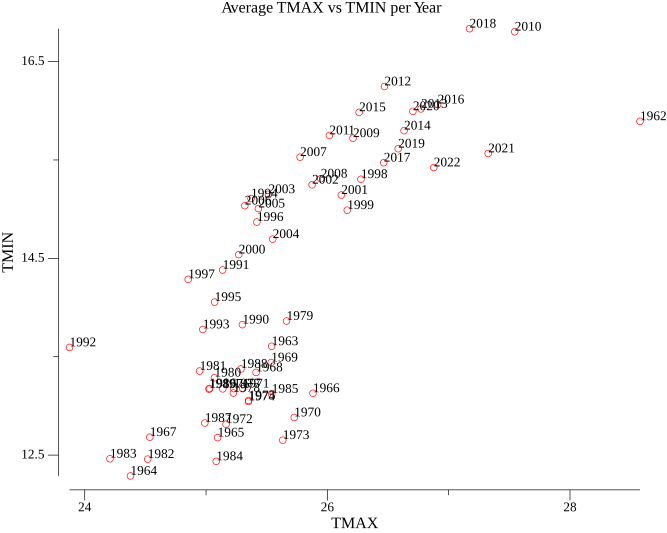

In [103]:
import (
	"encoding/csv"
	"fmt"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
	"log"
	"os"
	"strconv"
	"strings"
)

type TempSummary struct {
	TMaxTotal float64
	TMinTotal float64
	Count     int
}

func index(slice []string, item string) int {
	for i, val := range slice {
		if val == item {
			return i
		}
	}
	return -1
}

%%
header := csv_records[0]
csv_records = csv_records[1:]

yearlySummary := map[string]*TempSummary{}

for _, row := range csv_records {
	if row[index(header, "STATION")] == "ISE00105694" {
		year := row[index(header, "DATE")][:4]
		tmax, err1 := strconv.ParseFloat(row[index(header, "TMAX")], 64)
		tmin, err2 := strconv.ParseFloat(row[index(header, "TMIN")], 64)

		if err1 == nil && err2 == nil {
			if _, ok := yearlySummary[year]; !ok {
				yearlySummary[year] = &TempSummary{}
			}
			yearlySummary[year].TMaxTotal += tmax
			yearlySummary[year].TMinTotal += tmin
			yearlySummary[year].Count++
		}
	}
}

scatterData := make(plotter.XYs, len(yearlySummary))
labelsData := make([]string, len(yearlySummary))

i := 0
for year, summary := range yearlySummary {
	tmaxAvg := summary.TMaxTotal / float64(summary.Count)
	tminAvg := summary.TMinTotal / float64(summary.Count)

	scatterData[i].X = tmaxAvg
	scatterData[i].Y = tminAvg

	labelsData[i] = year

	i++
}

p := plot.New()

p.Title.Text = "Average TMAX vs TMIN per Year"
p.X.Label.Text = "TMAX"
p.Y.Label.Text = "TMIN"

s, err := plotter.NewScatter(scatterData)
if err != nil {
	log.Fatal(err)
}

labels, err := plotter.NewLabels(plotter.XYLabels{
	XYs: scatterData,
	Labels: labelsData,
})

if err != nil {
	log.Fatal(err)
}
s.Color = color.RGBA{255, 0, 0, 255}

p.Add(s, labels)

buf := bytes.NewBuffer(nil)
writerTo, err := p.WriterTo(vg.Points(float64(500)), vg.Points(float64(400)), "png")
if err != nil {
	panic(err)
}
writerTo.WriteTo(buf)
gonbui.DisplayPNG(buf.Bytes())


this code processes temperature data from csv_records, calculates the average TMAX and TMIN values per year for a specific station - ISE00105694, creates a scatter plot of TMAX vs TMIN, and displays the plot with color-coded points and a legend using the gonbui package using this [example] (https://github.com/gonum/plot/blob/master/plotter/scatterColor_example_test.go)

The code iterates over the remaining csv_records and performs the following steps:

- Checks if the station ID (row[index(header, "STATION")]) matches the value "ISE00105694". If not, it skips the current iteration.
- Extracts the year from the "DATE" field (row[index(header, "DATE")][:4]).
- Parses the TMAX and TMIN values from the corresponding columns (row[index(header, "TMAX")] and row[index(header, "TMIN")]) using strconv.ParseFloat.
- If both TMAX and TMIN values were successfully parsed, it updates the TempSummary for the corresponding year in yearlySummary. If the year is not present in yearlySummary, a new TempSummary is created. The TMAX and TMIN values are added to the running totals, and the count is incremented.

The code populates scatterData by iterating over the yearlySummary map. For each year and corresponding TempSummary, it calculates the average TMAX and TMIN values and assigns them to scatterData[i].X and scatterData[i].Y, respectively. The year is parsed as a float and stored in scatterData[i].Z.

A legend is created for the plot by iterating over the thumbnails. Labels and color swatches are added to the legend using p.Legend.Add. The minimum and maximum Z values are included as labels for the first and last items in the legend.

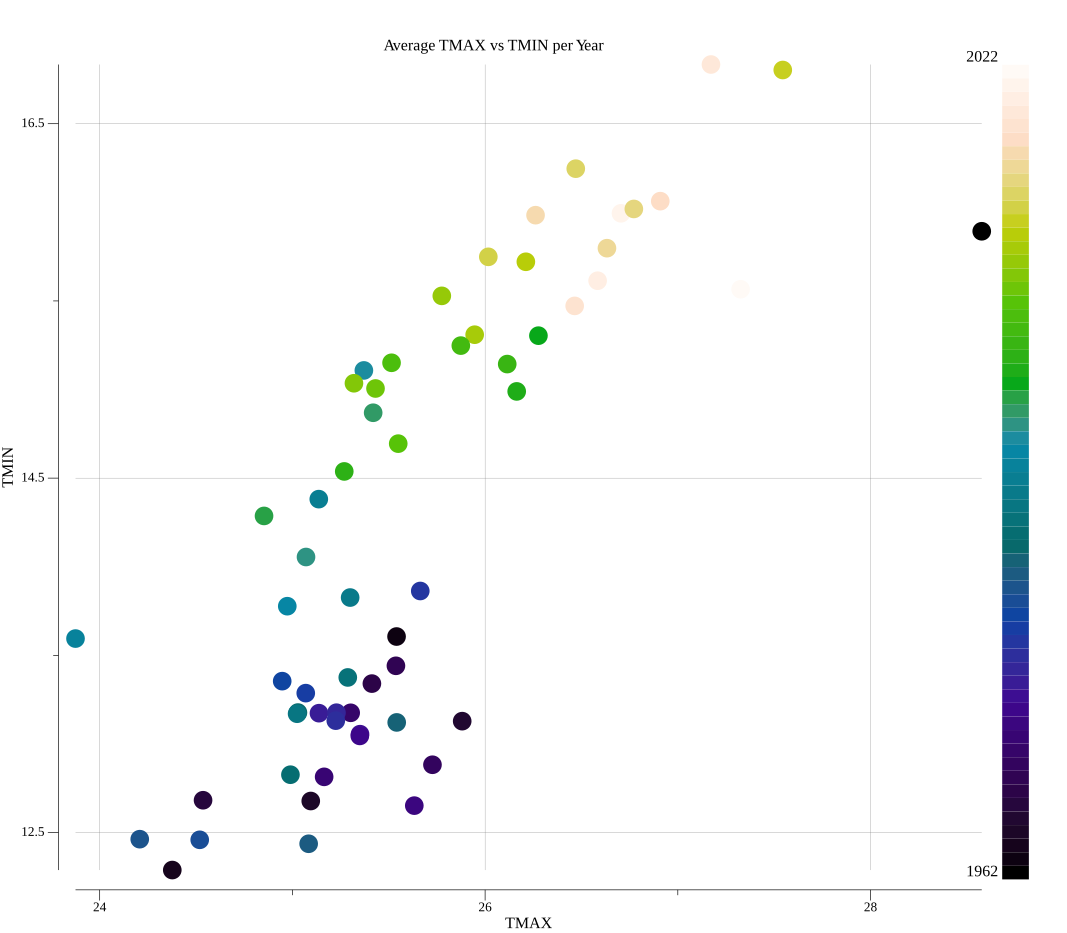

In [118]:
import (
	"encoding/csv"
	"fmt"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
	"log"
	"os"
	"strconv"
	"strings"
)

type TempSummary struct {
	TMaxTotal float64
	TMinTotal float64
	Count     int
}

func index(slice []string, item string) int {
	for i, val := range slice {
		if val == item {
			return i
		}
	}
	return -1
}

%%

header := csv_records[0]
csv_records = csv_records[1:]

yearlySummary := map[string]*TempSummary{}

for _, row := range csv_records {
	if row[index(header, "STATION")] == "ISE00105694" {
		year := row[index(header, "DATE")][:4]
		tmax, err1 := strconv.ParseFloat(row[index(header, "TMAX")], 64)
		tmin, err2 := strconv.ParseFloat(row[index(header, "TMIN")], 64)

		if err1 == nil && err2 == nil {
			if _, ok := yearlySummary[year]; !ok {
				yearlySummary[year] = &TempSummary{}
			}
			yearlySummary[year].TMaxTotal += tmax
			yearlySummary[year].TMinTotal += tmin
			yearlySummary[year].Count++
		}
	}
}

scatterData := make(plotter.XYZs, len(yearlySummary))

i := 0
for year, summary := range yearlySummary {
	tmaxAvg := summary.TMaxTotal / float64(summary.Count)
	tminAvg := summary.TMinTotal / float64(summary.Count)

	scatterData[i].X = tmaxAvg
	scatterData[i].Y = tminAvg
	if year_float, err := strconv.ParseFloat(year, 2); err == nil {
		scatterData[i].Z = year_float
	}
	i++
}


// Calculate the range of Z values.
minZ, maxZ := math.Inf(1), math.Inf(-1)
for _, xyz := range scatterData {
	if xyz.Z > maxZ {
		maxZ = xyz.Z
	}
	if xyz.Z < minZ {
		minZ = xyz.Z
	}
}

colors := moreland.Kindlmann() // Initialize a color map.
colors.SetMax(maxZ)
colors.SetMin(minZ)

p := plot.New()
p.Title.Text = "Average TMAX vs TMIN per Year"
p.X.Label.Text = "TMAX"
p.Y.Label.Text = "TMIN"
p.Add(plotter.NewGrid())

sc, err := plotter.NewScatter(scatterData)
if err != nil {
	log.Panic(err)
}

// Specify style and color for individual points.
sc.GlyphStyleFunc = func(i int) draw.GlyphStyle {
	_, _, z := scatterData.XYZ(i)
	d := (z - minZ) / (maxZ - minZ)
	rng := maxZ - minZ
	k := d*rng + minZ
	c, err := colors.At(k)
	if err != nil {
		log.Panic(err)
	}
	return draw.GlyphStyle{Color: c, Radius: vg.Points(7), Shape: draw.CircleGlyph{}}
}
p.Add(sc)

//Create a legend
thumbs := plotter.PaletteThumbnailers(colors.Palette(len(scatterData)))
for i := len(thumbs) - 1; i >= 0; i-- {
	t := thumbs[i]
	if i != 0 && i != len(thumbs)-1 {
		p.Legend.Add("", t)
		continue
	}
	var val int
	switch i {
	case 0:
		val = int(minZ)
	case len(thumbs) - 1:
		val = int(maxZ)
	}
	p.Legend.Add(fmt.Sprintf("%d", val), t)
}

// This is the width of the legend, experimentally determined.
const legendWidth = vg.Centimeter

// Slide the legend over so it doesn't overlap the ScatterPlot.
p.Legend.XOffs = legendWidth

img := vgimg.New(800, 700)
dc := draw.New(img)
dc = draw.Crop(dc, 0, -2*legendWidth, 0, -vg.Centimeter) // Make space for the legend.
p.Draw(dc)


png := vgimg.PngCanvas{Canvas: img}
buf := bytes.NewBuffer(nil)
png.WriteTo(buf)
gonbui.DisplayPNG(buf.Bytes())


This code processes weather data from csv_records for a specific station ISM00040180, creates a heatmap of the average temperature over the years, and displays the heatmap as a PNG image using the gonbui package.

The code creates a 2D slice called dataset to store the heatmap data. The rows represent days of the year, and the columns represent years. Each cell is initialized with NaN.

The code populates the dataset with the data from the heatmapData map, swapping the rows and columns accordingly.

The code finds the indices of non-empty columns in the dataset and creates a new dataset called newDataset with only the non-empty columns.

[[NaN 19 12.9 NaN NaN NaN NaN NaN 14.6 12.7 16.8 13.3 11.2 13.2 13.4 20.7 12.4 11.7 NaN NaN NaN 12.6 11.5 18.6 12.8 NaN NaN NaN NaN NaN 8.1 11.5 14.7 13.6 13.9 11.6 12.6 11.8 10.7 13.9 7.3 12.6 12.4 14 10.8 13.4 7.9 13.2 11.6 6.9 11.1 18.7 13.4 14.4 13.2 12.6 15 17 15.7 14.2 15.2 13.4 15.7 15.5 11.3 13.3 10.2 16.6 15.2 14.1 15.1 12.7 14.3 11.1 11.7 12.3 12.7 13.4 15.2 15.4] [NaN 18.1 10.3 NaN NaN NaN NaN NaN 15.8 12.4 18.7 12.4 11.8 12.8 13.3 19.7 17.6 10.9 NaN NaN NaN 12.9 12.9 15.2 10.6 NaN NaN NaN NaN NaN 7.4 13.5 13.3 12.4 12.9 12.2 15.3 12.5 13.3 12.1 8.4 12.8 12.5 15.6 11.8 13.6 9.7 15.8 12.6 4.3 10.9 15.4 12.4 14.2 13.2 10.9 16.3 17.1 13.8 14.9 14.8 14.7 15.2 14.6 12.1 14.6 10 16.9 15.8 12.1 15.4 13.1 12.9 10.1 11.7 14.9 13.8 13 15.8 14.9] [NaN 16.7 10.3 NaN NaN NaN NaN NaN 14.7 13 19.7 11.5 13.3 13.2 12.8 14.3 17 12.9 NaN 13.5 NaN 13.1 15.3 12.9 11.4 NaN NaN NaN NaN NaN 10.8 14.9 11.6 11.6 13 10.2 15.7 12.8 12.1 13.4 8.7 12.2 10.7 13.9 13.3 12.7 10.1 14.8 14.8 7.2 12 15.6 12.6 

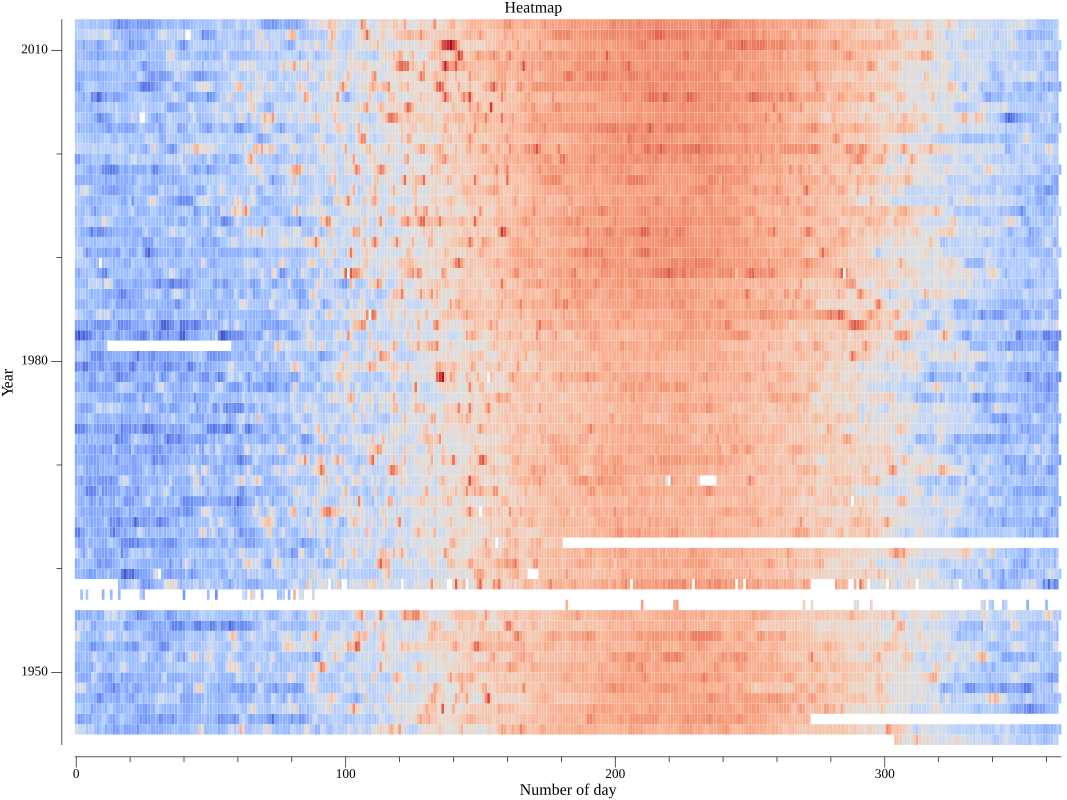

In [7]:
import (
	"encoding/csv"
	"bytes"
	"fmt"
	"os"
	"strconv"
	"time"
	"gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/vg"
    "gonum.org/v1/plot/plotutil"
    "github.com/janpfeifer/gonb/gonbui"
	"gonum.org/v1/plot/palette"
)

type plottable struct {
	grid [][]float64
	N int
	M int
	resolution float64
	minX float64
	minY float64
  }

func (p plottable) Dims() (c, r int) {
	return p.N, p.M
}
func (p plottable) X(c int) float64 {
	return p.minX + float64(c)*p.resolution
}
func (p plottable) Y(r int) float64 {
	return p.minY + float64(r)*p.resolution
}
func (p plottable) Z(c, r int) float64 {
	return p.grid[c][r]
}

func isColumnEmpty(dataset [][]float64, col int) bool {
	for _, row := range dataset {
		if !math.IsNaN(row[col]) {
			return false
		}
	}
	return true
}

type WeatherData struct {
	Station   string
	Name      string
	Latitude  float64
	Longitude float64
	Elevation float64
	Date      time.Time
	Tavg      float64
	Tmax      float64
	Tmin      float64
}

%%
// create a map to hold the heatmap data
heatmapData := make(map[int]map[int]float64)

minYear := math.MaxInt64
maxYear := math.MinInt64

for i, line := range csv_records {
	if i == 0 {
		continue // skip header
	}

	if line[0] != "ISM00040180" {
		continue // skip other stations
	}

	tavg, _ := strconv.ParseFloat(line[6], 64)
	date, _ := time.Parse("2006-01-02", line[5])

	year := date.Year()
	dayOfYear := date.YearDay()

	if year < minYear {
		minYear = year
	}
	if year > maxYear {
		maxYear = year
	}

	// check if the year is already in the map
	if _, ok := heatmapData[year]; !ok {
		heatmapData[year] = make(map[int]float64)
	}

	heatmapData[year][dayOfYear] = tavg
}

numYears := maxYear - minYear + 1

// create a 2D slice
dataset := make([][]float64, 366) // Now days are rows
for i := range dataset {
	dataset[i] = make([]float64, numYears) // and years are columns
	for j := range dataset[i] {
		dataset[i][j] = math.NaN()
	}
}

// populate the 2D slice with data from the map
for year, data := range heatmapData {
	j := year - minYear
	for dayOfYear, tavg := range data {
		dataset[dayOfYear-1][j] = tavg // Now we are swapping the rows and columns
	}
}

// find the indices of non-empty columns.
nonEmptyColumns := make([]int, 0)
for j := 0; j < numYears; j++ {
	if !isColumnEmpty(dataset, j) {
		nonEmptyColumns = append(nonEmptyColumns, j)
	}
}

// create a new dataset with the non-empty columns.
newDataset := make([][]float64, len(dataset))
for i := range newDataset {
	newDataset[i] = make([]float64, len(nonEmptyColumns))
	for j, col := range nonEmptyColumns {
		newDataset[i][j] = dataset[i][col]
	}
}

dataset = newDataset

plotData := plottable{
	grid: dataset,
	N: len(dataset),
	M: len(dataset[0]),
	minX: 0,
	minY: float64(minYear) + 0.5,
	resolution: 1,
	}
	pal := moreland.SmoothBlueRed().Palette(255)
	hm := plotter.NewHeatMap(plotData, pal)

p := plot.New()
p.Title.Text = "Heatmap"
p.X.Label.Text = "Number of day"
p.Y.Label.Text = "Year"

p.Add(hm)

buf := bytes.NewBuffer(nil)
writerTo, err := p.WriterTo(vg.Length(800), vg.Length(600), "png")
if err != nil {
	panic(err)
}
writerTo.WriteTo(buf)
gonbui.DisplayPNG(buf.Bytes())


In summary, the code reads and parses weather records from a CSV file, groups the records by year, calculates the annual mean temperatures, normalizes the temperatures, and prints the resulting normalized temperatures and corresponding years. The purpose of this code snippet is to prepare the data for climate stripe plot.

Climate stripe plots typically involve creating a complex visual representation with color gradients or stripes that span multiple years. Achieving this level of customization and visual complexity may require advanced features and capabilities that are not readily available in existing Go plotting libraries.

In [10]:
//climate stripes plot 
import (
	"encoding/csv"
	"bytes"
	"fmt"
	"os"
	"strconv"
	"time"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
    "github.com/janpfeifer/gonb/gonbui"
)

type WeatherRecord struct {
	Station string
	Date    time.Time
	TAVG    float64
}

%%

// Parse records into a slice of WeatherRecords
var weatherRecords []WeatherRecord
for i, record := range csv_records {
	// Skip the header
	if i == 0 {
		continue
	}

	if record[0] != "ISM00040180" {
		continue // skip other stations
	}


	tavg, _ := strconv.ParseFloat(record[6], 64)
	date, _ := time.Parse("2006-01-02", record[5])

	// Append the record to the slice
	weatherRecords = append(weatherRecords, WeatherRecord{
		Station: record[0],
		Date:    date,
		TAVG:    tavg,
	})
}

// Group by year and calculate the average temperature
yearTemps := make(map[int][]float64)
for _, record := range weatherRecords {
	yearTemps[record.Date.Year()] = append(yearTemps[record.Date.Year()], record.TAVG)
}

// Compute annual mean temperatures
annualMeanTemps := make(map[int]float64)
for year, temps := range yearTemps {
	var sum float64
	for _, temp := range temps {
		sum += temp
	}
	annualMeanTemps[year] = sum / float64(len(temps))
}

// Sort the years
var years []int
for year := range annualMeanTemps {
	years = append(years, year)
}
sort.Ints(years)  // sorts in ascending order

// Normalize the temperatures using the sorted years
var minTemp, maxTemp float64
for _, year := range years {
	temp := annualMeanTemps[year]
	if temp < minTemp || minTemp == 0 {
		minTemp = temp
	}
	if temp > maxTemp {
		maxTemp = temp
	}
}

normalizedTemps := make([]float64, len(annualMeanTemps))
for i, year := range years {
	temp := annualMeanTemps[year]
	normalizedTemps[i] = (temp - minTemp) / (maxTemp - minTemp)
}

fmt.Println(normalizedTemps)
fmt.Println(years)


[0.3813398555832283 0.6451229531431373 0.6359653325934557 0.6587925152486279 0.6509363547422499 0.5495309524682901 0.6454464205320405 0.7241040074967547 0.6701741245077505 0.73879238185438 0.7468844105474811 0.4920813838319519 0.6912094592413949 0.5871666688572087 0 0.7155964318943706 0.5159287053183631 0.6098951854680306 0.6759736946538951 0.10859315568924638 0.5702787606340233 0.5809402960685368 0.6027007140953348 0.536951874689437 0.5305472832593552 0.5689342313623007 0.6628577050186242 0.6045821262019277 0.5655616064669529 0.4945741888795864 0.48874486015280383 0.5382252066330674 0.5741905470164707 0.5169327326145629 0.48395100429195886 0.503701690438636 0.5308924408813365 0.5649863437636501 0.7356240488799164 0.48712846626188766 0.6158395667354746 0.7127239204804602 0.6283802936674407 0.696716892335293 0.6558395000383481 0.8306185720128981 0.8204397544842155 0.7020713411765878 0.7953982318592145 0.8071335910065557 0.8185237925319203 0.7901137785526758 0.7244491651187366 0.71950190